In [1]:
from scripts.open_preprocess_racmo import *
from scripts.paths import *
from scripts.dicts import *

from sum_freshwater_func import *

import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import numpy as np

import plotly.express as px

import pandas as pd

Pathdata: /Volumes/imau01/rapid/RACMO2.3p2/FGRN055
Reading locally reprojected 1k data
Finished reading locally reprojected 1k data
Opening file: 
 /Volumes/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/runoff.1958-2023.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz
... 
/Volumes/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/runoff.1958-2023.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz
Opened /Volumes/imau02/rapid/Anneke/RACMO2.3p2/FGRN055/Downscaling_GR_500m/Annual/Sums and masks/runoff.1940-2023.BN_RACMO2.3p2_ERA5_3h_1940_FGRN055.GrIS.0.5km.GIC.YY.nc
Opened /Volumes/imau02/rapid/Anneke/RACMO2.3p2/FGRN055/Downscaling_GR_500m/Annual/Sums and masks/runoff.1940-2023.BN_RACMO2.3p2_ERA5_3h_1940_FGRN055.GrIS.0.5km.GrIS.YY.nc
Opened /Volumes/imau02/rapid/Anneke/RACMO2.3p2/FGRN055/Downscaling_GR_500m/Annual/Sums and masks/runoff_yearly_sum.1940-2023.BN_RACMO2.3p2_ERA5_3h_1940_FGRN055.GrIS.0.5km.GIC.YY.nc
Opened /Volumes/imau02/rapid/Anneke/RACMO2.3p2/FGRN055/Downscaling_GR_500m/Annu

In [3]:
fname = pathIMAU02 + "RACMO2.3p2/FGRN055/Downscaling_GR/masks1k.nc"
mask1 = xr.open_dataset(fname)

fname = (
    pathIMAU02
    + "RACMO2.3p2/FGRN055/Downscaling_GR/Mask_adjusted_section_numbers_slater_may24_copy.nc"
)
mask_regions = xr.open_dataset(fname)

mask_regions['section_numbers_adjusted'].plot()

make regions data array

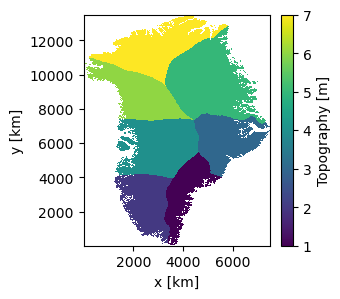

In [102]:
da_regions = xr.zeros_like(mask1['LSM']) 
da_regions.values = (mask1['LSM'].values*mask_regions['section_numbers_adjusted'].values)
da_regions = da_regions.where(da_regions>0)
da_regions.name = 'region'
da_regions.plot.imshow(figsize=(3,3))

# open racmo precip annual

In [28]:
precipRACMO1kmAnnual = pathIMAU02 + "RACMO2.3p2/FGRN055/Downscaling_GR/Annual/precip.1958-2023.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz"
dsprecipRACMO1kmAnnual = xr.open_mfdataset(precipRACMO1kmAnnual, decode_times=False)


# Extract the time values (years since reference)
years_since_ref = dsprecipRACMO1kmAnnual['time'].values
ref_year = 1958
actual_years = ref_year + years_since_ref.astype(int)
new_dates = np.array([np.datetime64(f'{year}-01-01') for year in actual_years])
dsprecipRACMO1kmAnnual['time'] = new_dates

/var/folders/cv/s_h5gzxd0h71t_d875wqxgzh0000gn/T/ipykernel_3719/4105770296.py:10: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  dsprecipRACMO1kmAnnual['time'] = new_dates
/var/folders/cv/s_h5gzxd0h71t_d875wqxgzh0000gn/T/ipykernel_3719/4105770296.py:10: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the D

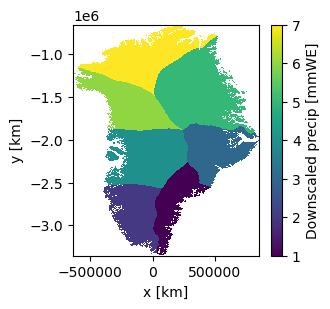

In [103]:
dsprecipRACMO1kmAnnual['regions'] = xr.zeros_like(dsprecipRACMO1kmAnnual['precipcorr'].isel(time=0))
dsprecipRACMO1kmAnnual['regions'].values = da_regions.values

dsprecipRACMO1kmAnnual['regions'].plot.imshow(figsize=(3,3))

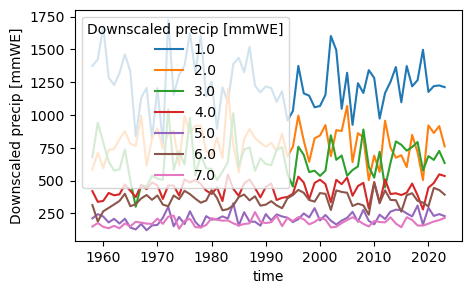

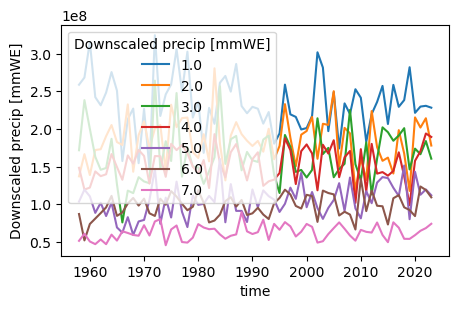

In [108]:
dsprecipRACMO1kmAnnual_mean_region = dsprecipRACMO1kmAnnual['precipcorr'].groupby(dsprecipRACMO1kmAnnual['regions']).mean()
dsprecipRACMO1kmAnnual_mean_region.plot.line(x='time', figsize=(5,3))
plt.show()

dsprecipRACMO1kmAnnual_sum_region = dsprecipRACMO1kmAnnual['precipcorr'].groupby(dsprecipRACMO1kmAnnual['regions']).sum()
dsprecipRACMO1kmAnnual_sum_region.plot.line(x='time', figsize=(5,3))

In [321]:
dfprecipRACMO1kmAnnual_mean_region = dsprecipRACMO1kmAnnual_mean_region.sel(time=slice('1990',None)).mean(dim='time').to_dataframe().round().reset_index()
dfprecipRACMO1kmAnnual_mean_region['Basins'] = dfprecipRACMO1kmAnnual_mean_region['regions'].astype(int).map(dict_sections)
dfprecipRACMO1kmAnnual_mean_region.to_csv(pathDataTemp+'RACMO2.3p2_FGRN055_1km_mean_precip_per_region_1990-2022.csv')
dfprecipRACMO1kmAnnual_sum_region = dsprecipRACMO1kmAnnual_sum_region.sel(time=slice('1990',None)).mean(dim='time').to_dataframe().round().reset_index()
dfprecipRACMO1kmAnnual_sum_region['Basins'] = dfprecipRACMO1kmAnnual_sum_region['regions'].astype(int).map(dict_sections)
dfprecipRACMO1kmAnnual_sum_region.to_csv(pathDataTemp+'RACMO2.3p2_FGRN055_1km_sum_precip_per_region_1990-2022.csv')

In [153]:

# dfprecipRACMO1kmAnnual_mean_region = pd.read_csv(pathDataTemp+'RACMO2.3p2_FGRN055_1km_mean_precip_per_region_1990-2022.csv')
# dfprecipRACMO1kmAnnual_sum_region = pd.read_csv(pathDataTemp+'RACMO2.3p2_FGRN055_1km_sum_precip_per_region_1990-2022.csv')


In [143]:
df_per_region_abs = pd.read_csv(pathDataProcessed + 'Mean_Freshwater_components_annual_per_region_absolute_1990_2022.csv')
df_per_region_rel = pd.read_csv(pathDataProcessed + 'Mean_Freshwater_components_annual_per_region_relative_1990_2022.csv')

In [322]:
dfprecipRACMO1kmAnnual_mean_region = dsprecipRACMO1kmAnnual_mean_region.sel(time=slice('1990',None)).mean(dim='time').to_dataframe().round().reset_index()
dfprecipRACMO1kmAnnual_mean_region['Basins'] = dfprecipRACMO1kmAnnual_mean_region['regions'].astype(int).map(dict_sections)
dfprecipRACMO1kmAnnual_mean_region

,regions,precipcorr,Basins
0,1.0,1209.0,SE
1,2.0,777.0,SW
2,3.0,656.0,CE
3,4.0,435.0,CW
4,5.0,229.0,NE
5,6.0,362.0,NW
6,7.0,187.0,NO


Absolute

In [342]:

df_mean_precip_abs_flux = pd.merge(df_per_region_abs, dfprecipRACMO1kmAnnual_sum_region)
df_abs = df_mean_precip_abs_flux.set_index(['precipcorr', 'Basins']).stack().reset_index().rename(columns={'level_2':'FW component', 0:'Flux'})

# for both drop column 'regions'
# df_abs = df_abs.drop(columns=['regions'])


In [343]:
label_rename = {
    'precipcorr': 'Precipitation (mm yr<sup>-1</sup> km<sup>-2</sup>)', 
    'Flux': 'Flux (Gt yr<sup>-1</sup>)',
}


fig = px.scatter(df_abs.rename(columns=label_rename), x=label_rename['precipcorr'], y=label_rename['Flux'],color='FW component', facet_col='FW component',facet_col_wrap=3,trendline='ols', facet_col_spacing=0.05, facet_row_spacing=0.15, template='plotly_white', text='Basins')
fig.update_traces(textposition='top center')
fig.update_yaxes(matches=None)
results = px.get_trendline_results(fig)


# Assuming 'results' contains the trendline results and 'fig' is your Plotly Express figure

# Initialize a list to hold correlation coefficients
correlation_coefficients = []
r_squared_values = []
names = []

# Calculate correlation coefficients from the R-squared values
for i, result in enumerate(results.px_fit_results):
    FW_comp = results['FW component'][i]
    names.append(FW_comp)
    correlation_coefficient = np.sqrt(result.rsquared)
    correlation_coefficients.append(correlation_coefficient)
    r_squared = result.rsquared
    correlation_coefficient = np.sqrt(r_squared)
    correlation_coefficients.append(correlation_coefficient)
    r_squared_values.append(r_squared)
    print(f"{FW_comp}: R² = {r_squared:.2f}")



def add_annotations(fig, r_squared_values, correlation_coefficients):
    for i, annotation in enumerate(fig.layout.annotations):
        # new_text = f"{annotation.text}<br>{names[i]}<br> R²: {r_squared_values[i]:.2f}, Corr: {correlation_coefficients[i]:.2f}"
        # annotation.text = new_text
        annotation.text = "{}".split("=")[1]
fig.for_each_yaxis(lambda axis: axis.update(showticklabels=True))
# Add the annotations to the plot
# add_annotations(fig, r_squared_values, correlation_coefficients)

# split tile at "="
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i].text = fig.layout.annotations[i].text.split("=")[1]

fig.update_yaxes(range=[0, None])  # Y-axis starts at 0
fig.update_xaxes(range=[0, None])
# change y and x labels


fig.write_image(pathFigures+'scatter_precip_corr_FW_components_abs_Gtyr-1.png', width=1000, height=800, scale=2)
fig.show()

Solid Ice Discharge: R² = 0.27
Liquid Runoff Ice Sheet: R² = 0.43
Liquid Runoff Tundra: R² = 0.22
Liquid Runoff Ice Caps: R² = 0.21
Precipitation Fjords: R² = 0.79
Precipitation Fjords CARRA: R² = 0.72
regions: R² = 0.98


In [346]:
df_abs

,precipcorr,Basins,FW component,Flux
0,227851728.0,SE,Solid Ice Discharge,138.112891
1,227851728.0,SE,Liquid Runoff Ice Sheet,48.303806
2,227851728.0,SE,Liquid Runoff Tundra,25.591066
3,227851728.0,SE,Liquid Runoff Ice Caps,18.863214
4,227851728.0,SE,Precipitation Fjords,14.380771
5,227851728.0,SE,Precipitation Fjords CARRA,12.396037
6,227851728.0,SE,regions,1.000000
7,181856352.0,SW,Solid Ice Discharge,19.206346
8,181856352.0,SW,Liquid Runoff Ice Sheet,80.485110
9,181856352.0,SW,Liquid Runoff Tundra,54.700966


Relative

In [347]:
df_per_region_rel_reform = df_per_region_rel.rename(columns={'Unnamed: 0':'FW component'}).set_index('FW component').T.reset_index().rename(columns={'index':'Basins'})
df_mean_precip_rel_flux = pd.merge(df_per_region_rel_reform, dfprecipRACMO1kmAnnual_sum_region)
df_rel = df_mean_precip_rel_flux.set_index(['precipcorr', 'Basins']).stack().reset_index().rename(columns={'level_2':'FW component', 0:'%'})
df_rel['%'] = df_rel['%']*100

In [349]:
label_rename = {
    'precipcorr': 'Precipitation (mm yr<sup>-1</sup>)', 
    '%': '% total input',
}

fig = px.scatter(df_rel.rename(columns=label_rename), x=label_rename['precipcorr'], y=label_rename['%'],color='FW component', facet_col='FW component',facet_col_wrap=3,trendline='ols', facet_col_spacing=0.05, facet_row_spacing=0.15, template='plotly_white', text='Basins')
fig.update_traces(textposition='top center')
fig.update_yaxes(matches=None, range=[0, None])
results = px.get_trendline_results(fig)

fig.update_yaxes()  # Y-axis starts at 0
fig.update_xaxes(range=[0, None])

# Assuming 'results' contains the trendline results and 'fig' is your Plotly Express figure

# Initialize a list to hold correlation coefficients
correlation_coefficients = []
r_squared_values = []
names = []

# Calculate correlation coefficients from the R-squared values
for i, result in enumerate(results.px_fit_results):
    FW_comp = results['FW component'][i]
    names.append(FW_comp)

    r_squared = result.rsquared
    r_squared_values.append(r_squared)
    print(f"{FW_comp}: R² = {r_squared:.2f}")


fig.for_each_yaxis(lambda axis: axis.update(showticklabels=True))
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i].text = fig.layout.annotations[i].text.split("=")[1]

# change y and x labels


fig.write_image(pathFigures+'scatter_precipSUM_corr_FW_components_rel.png', width=1000, height=600, scale=2)
fig.show()

Solid Ice Discharge: R² = 0.01
Liquid Runoff Ice Sheet: R² = 0.02
Liquid Runoff Tundra: R² = 0.00
Liquid Runoff Ice Caps: R² = 0.10
Precipitation Fjords: R² = 0.44
Precipitation Fjords CARRA: R² = 0.42
regions: R² = 0.98


In [355]:
df_rel[df_rel['FW component'] == 'Solid Ice Discharge']

,precipcorr,Basins,FW component,%
0,227851728.0,SE,Solid Ice Discharge,56.472381
7,181856352.0,SW,Solid Ice Discharge,11.301755
14,166274224.0,CE,Solid Ice Discharge,43.144793
21,154165920.0,CW,Solid Ice Discharge,47.026051
28,112069776.0,NE,Solid Ice Discharge,22.365931
35,100698056.0,NW,Solid Ice Discharge,69.743462
42,64593068.0,NO,Solid Ice Discharge,30.182850


In [364]:
df_corr = df_per_region_rel.set_index(["Unnamed: 0"]).corr()

In [389]:
import pandas as pd
import numpy as np

# Assuming df_per_region_rel is your DataFrame and it's already loaded

# Set index if not already set
df_corr = df_per_region_rel.set_index(["Unnamed: 0"]).corr()
# Apply the formatting
styled_df = (df_corr.style
             .background_gradient(cmap='Greens')
             .set_caption("Title")
             .format("{:.2f}")
            )

styled_df


,SE,SW,CE,CW,NE,NW,NO
SE,1.00,0.08,0.92,0.91,0.43,1.00,0.69
SW,0.08,1.00,0.40,0.46,0.92,0.10,0.72
CE,0.92,0.40,1.00,1.00,0.67,0.95,0.84
CW,0.91,0.46,1.00,1.00,0.72,0.92,0.88
NE,0.43,0.92,0.67,0.72,1.00,0.44,0.93
NW,1.00,0.10,0.95,0.92,0.44,1.00,0.70
NO,0.69,0.72,0.84,0.88,0.93,0.70,1.00


In [387]:
df_corr

,SE,SW,CE,CW,NE,NW,NO
SE,1.000000,0.077008,0.924160,0.905027,0.430162,0.995523,0.690657
SW,0.077008,1.000000,0.395664,0.459937,0.919461,0.099500,0.724343
CE,0.924160,0.395664,1.000000,0.996659,0.665752,0.945774,0.843511
CW,0.905027,0.459937,0.996659,1.000000,0.722967,0.924941,0.883875
NE,0.430162,0.919461,0.665752,0.722967,1.000000,0.438832,0.932505
NW,0.995523,0.099500,0.945774,0.924941,0.438832,1.000000,0.696405
NO,0.690657,0.724343,0.843511,0.883875,0.932505,0.696405,1.000000


In [403]:
# Solid Ice Discharge	Liquid Runoff Ice Sheet	Liquid Runoff Tundra	Liquid Runoff Ice Caps	Precipitation Fjords	Precipitation Fjords CARRA

short_dict = {
    'Solid Ice Discharge': 'SID',
    'Liquid Runoff Ice Sheet': 'L_GrIS',
    'Liquid Runoff Tundra': 'L_Tundra',
    'Liquid Runoff Ice Caps': 'L_GIC',
    'Precipitation Fjords': 'P_RACMO',
    'Precipitation Fjords CARRA': 'P_CARRA',
}

df_per_region_rel.set_index(["Unnamed: 0"]).T.corr().rename(index=short_dict, columns=short_dict).style.background_gradient(cmap='PiYG_r').set_caption("Title").format("{:.2f}")
            


Unnamed: 0,SID,L_GrIS,L_Tundra,L_GIC,P_RACMO,P_CARRA
Unnamed: 0,,,,,,
SID,1.00,-0.88,-0.98,-0.53,-0.34,-0.23
L_GrIS,-0.88,1.00,0.83,0.13,0.16,0.07
L_Tundra,-0.98,0.83,1.00,0.53,0.28,0.17
L_GIC,-0.53,0.13,0.53,1.00,0.14,0.09
P_RACMO,-0.34,0.16,0.28,0.14,1.00,0.99
P_CARRA,-0.23,0.07,0.17,0.09,0.99,1.00


In [414]:
import pandas as pd

def style_dataframe(df, short_dict):
    """
    Styles the DataFrame with a background gradient, sets a caption, and formats numbers.
    
    Parameters:
    - df: DataFrame to be styled.
    - short_dict: Dictionary for renaming index and columns.
    
    Returns:
    - A pandas.io.formats.style.Styler object with the specified styles applied.
    """
    return df.rename(index=short_dict, columns=short_dict).style.background_gradient(cmap='PRGn',vmin=-1, vmax=1).set_caption("Correlation Matrix").format("{:.2f}")

style_dataframe(df_per_region_rel.set_index(["Unnamed: 0"]).T.corr(), short_dict)

Unnamed: 0,SID,L_GrIS,L_Tundra,L_GIC,P_RACMO,P_CARRA
Unnamed: 0,,,,,,
SID,1.00,-0.88,-0.98,-0.53,-0.34,-0.23
L_GrIS,-0.88,1.00,0.83,0.13,0.16,0.07
L_Tundra,-0.98,0.83,1.00,0.53,0.28,0.17
L_GIC,-0.53,0.13,0.53,1.00,0.14,0.09
P_RACMO,-0.34,0.16,0.28,0.14,1.00,0.99
P_CARRA,-0.23,0.07,0.17,0.09,0.99,1.00


In [432]:
df.reset_index()

FW,index,Solid Ice Discharge,Liquid Runoff Ice Sheet,Liquid Runoff Tundra,Liquid Runoff Ice Caps,Precipitation Fjords,Precipitation Fjords CARRA
0,SE,0.564724,0.195884,0.104144,0.076583,0.058666,0.050468
1,SW,0.113018,0.455487,0.318438,0.055969,0.057089,0.045344
2,CE,0.431448,0.311302,0.119846,0.058803,0.078601,0.073399
3,CW,0.470261,0.349936,0.117669,0.028214,0.033921,0.024992
4,NE,0.223659,0.358161,0.264800,0.104681,0.048698,0.038595
5,NW,0.697435,0.235449,0.035638,0.016088,0.015390,0.012383
6,NO,0.301829,0.331716,0.205943,0.131842,0.028671,0.020840


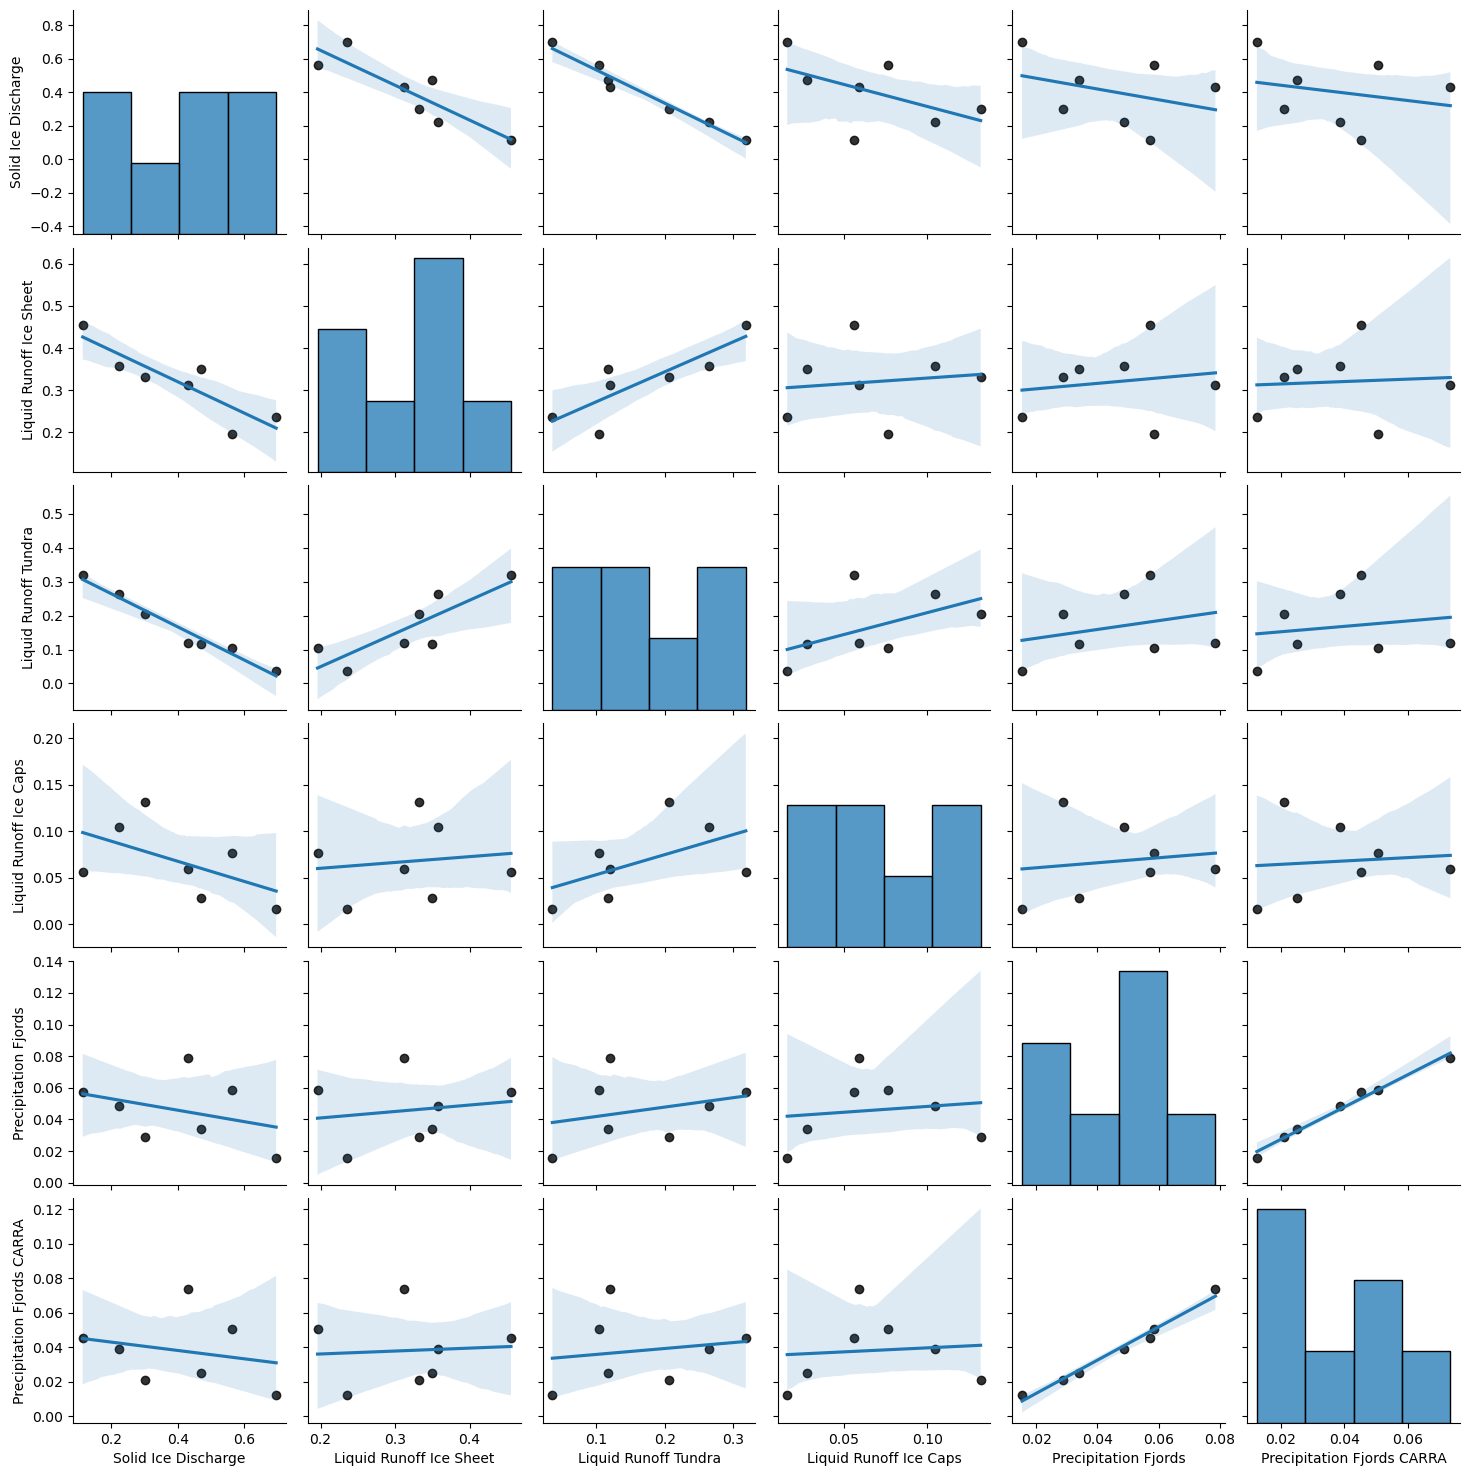

In [435]:
import seaborn as sns
df = df_per_region_rel.rename(columns={'Unnamed: 0':'FW'}).set_index('FW').T
sns.pairplot(df, kind='reg',  plot_kws={ 'scatter_kws': {'color': 'black'}})


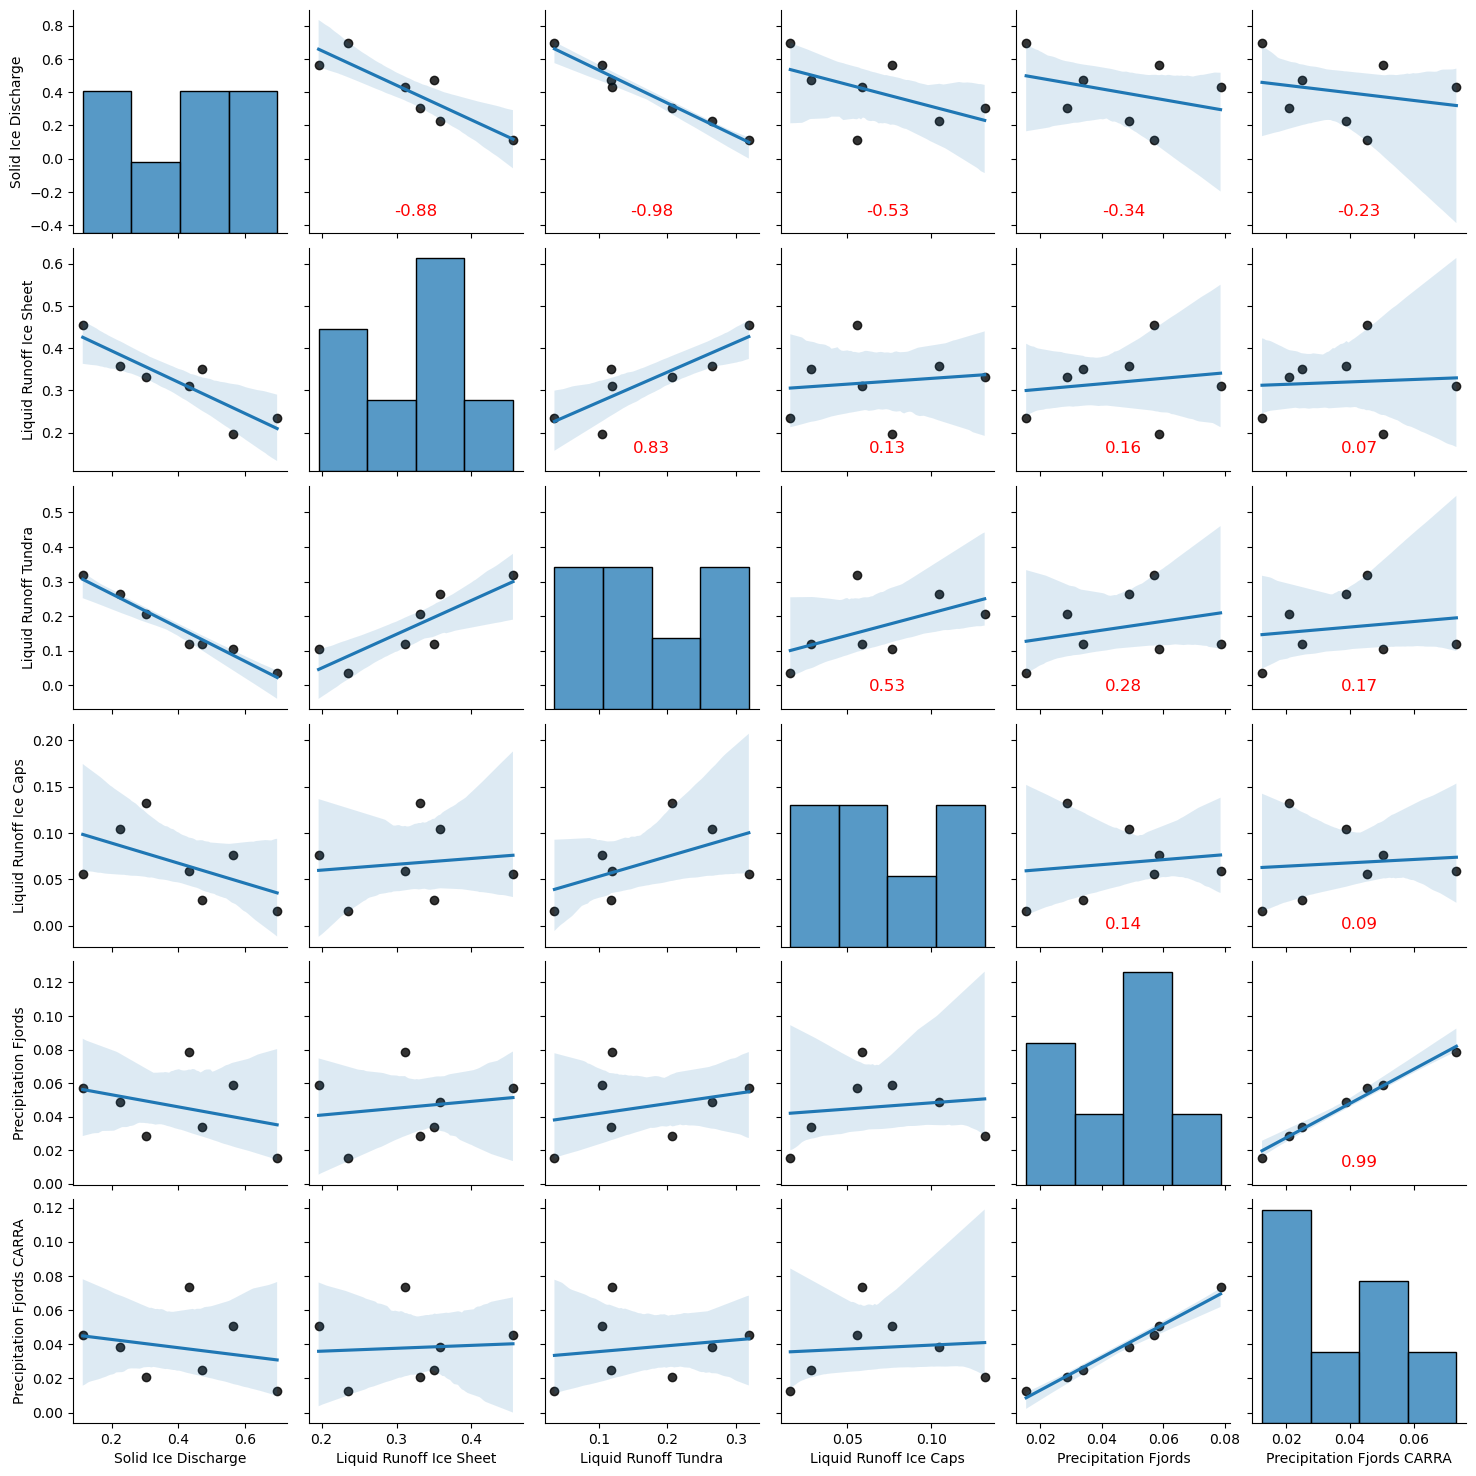

In [439]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load a sample dataset
data = sns.load_dataset('iris')

# Create the pair plot
pair_plot = sns.pairplot(df, kind='reg',  plot_kws={ 'scatter_kws': {'color': 'black'}})


# Calculate the correlation matrix
correlations = df.corr()

# Add correlation coefficients to the plot
for i, j in zip(*np.triu_indices_from(correlations, 1)):
    pair_plot.axes[i, j].annotate(f'{correlations.iloc[i, j]:.2f}', 
                                  xy=(0.5, 0.1), 
                                  xycoords='axes fraction', 
                                  ha='center', 
                                  va='center', 
                                  fontsize=12, 
                                  color='red')

plt.show()


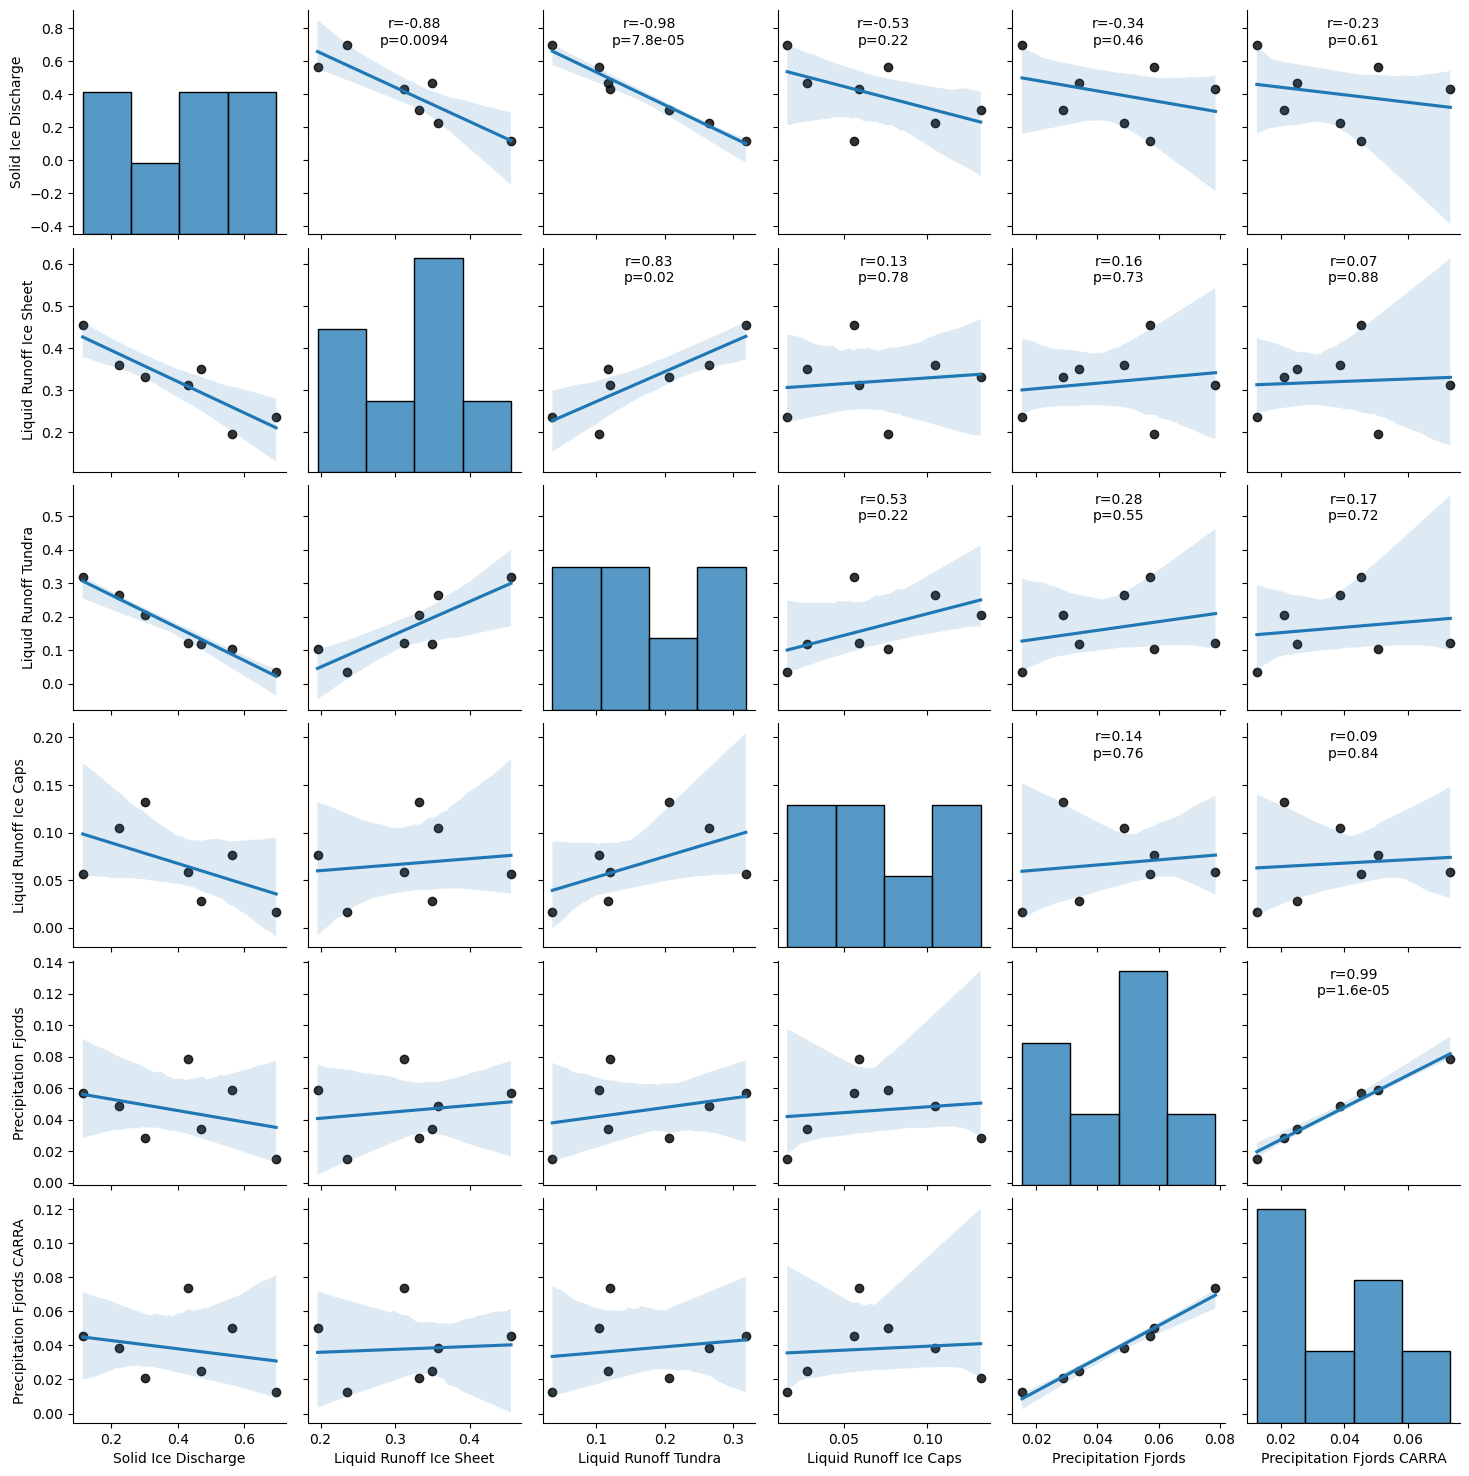

In [445]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr


# Create the pair plot
pair_plot = sns.pairplot(df, kind='reg',  plot_kws={ 'scatter_kws': {'color': 'black'}})

# Function to calculate correlation and p-value
def corrfunc(x, y):
    r, p = pearsonr(x, y)
    return r, p

# Add correlation coefficients and p-values to the plot
for i, j in zip(*np.triu_indices_from(pair_plot.axes, 1)):
    x = df.iloc[:, j]
    y = df.iloc[:, i]
    r, p = corrfunc(x, y)
    
    # Display correlation coefficient and p-value
    pair_plot.axes[i, j].annotate(f'r={r:.2f}\np={p:.2g}', 
                                  xy=(0.5, 0.9), 
                                  xycoords='axes fraction', 
                                  ha='center', 
                                  va='center', 
                                  fontsize=10, 
                                  color='black')



plt.show()
